In [1]:
import sys
sys.path.append('../centroFlye_repo/scripts')

import os
from collections import defaultdict, Counter
from copy import deepcopy
from itertools import accumulate

import numpy as np

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils.bio import read_bio_seq, compress_homopolymer
from read_kmer_cloud import get_reads_kmer_clouds
from ncrf_parser import NCRF_Report
from utils.various import get_kmers
from cloud_contig import CloudContig, map_reads_fast

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]


# centroFlye and Telomere-to-Telomere assemblies of cenX

## Obtaining T2T assemblies

In [3]:
T2T_dir = "../data/T2T"
centroFlye_results_dir = "../data/centroFlye_results"

Download T2T assemblies

In [4]:
t2t04_assembly_url = \
"https://s3.amazonaws.com/nanopore-human-wgs/chm13/assemblies/chm13.draft_v0.4.fasta.gz"
t2t06_assembly_url = \
"https://s3.amazonaws.com/nanopore-human-wgs/chm13/assemblies/chm13.draft_v0.6.fasta.gz"

! wget -P {T2T_dir} {t2t04_assembly_url}
! wget -P {T2T_dir} {t2t06_assembly_url}



--2020-06-16 17:36:32--  https://s3.amazonaws.com/nanopore-human-wgs/chm13/assemblies/chm13.draft_v0.4.fasta.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.248.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.248.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839307916 (800M) [binary/octet-stream]
Saving to: ‘../data/T2T/chm13.draft_v0.4.fasta.gz.2’

chm13.draft_v0.4.fa 100%[===================>] 800.43M  17.3MB/s    in 92s     

2020-06-16 17:38:04 (8.73 MB/s) - ‘../data/T2T/chm13.draft_v0.4.fasta.gz.2’ saved [839307916/839307916]

--2020-06-16 17:38:04--  https://s3.amazonaws.com/nanopore-human-wgs/chm13/assemblies/chm13.draft_v0.6.fasta.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 876252987 (836M) [binary/octet-stream]
Saving to: ‘../data/T2T/chm13.draft_v0.6.fasta.gz.2’



Unzip and index these assemblies

In [5]:
! gunzip -f {T2T_dir}/chm13.draft_v0.4.fasta.gz
! gunzip -f {T2T_dir}/chm13.draft_v0.6.fasta.gz

! faidx {T2T_dir}/chm13.draft_v0.4.fasta > /dev/null
! faidx {T2T_dir}/chm13.draft_v0.6.fasta > /dev/null


Extract cenX from both assemblies

In [6]:
t2t04_assembly_fn = os.path.join(T2T_dir, "cenX_v04.fasta")
t2t06_assembly_fn = os.path.join(T2T_dir, "cenX_v06.fasta")

In [7]:
! faidx {T2T_dir}/chm13.draft_v0.4.fasta "chrX_fixedBionanoSV_centromereV3":57811689-60534892  > {t2t04_assembly_fn}
! faidx {T2T_dir}/chm13.draft_v0.6.fasta "chrX_fixedBionanoSV_centromereV4_racon_patch139_arrow_arrow":57827622-60665308 > {t2t06_assembly_fn}


## Obtaining NCRF reports for all assemblies

Run NCRF on T2T assemblies and centroFlye assembly

In [8]:
centroFlye_assembly_fn = \
os.path.join(centroFlye_results_dir, "polishing1", "final_sequence_4.fasta")

centroFlye_ncrf_dir = \
os.path.join(centroFlye_results_dir, "polishing1", "NCRF_rc_star")

t2t04_ncrf_dir = \
os.path.join(T2T_dir, "NCRF_rc_star_T2T4")

t2t06_ncrf_dir = \
os.path.join(T2T_dir, "NCRF_rc_star_T2T6")


In [9]:
!python ../centroFlye_repo/scripts/run_ncrf_parallel.py \
    --reads {T2T_dir}/cenX_v04.fasta \
    -t 1 \
    --outdir {t2t04_ncrf_dir} \
    --repeat {centroFlye_results_dir}/DXZ1_star/DXZ1_rc_star.fasta

(1 alignment reported)


In [10]:
!python ../centroFlye_repo/scripts/run_ncrf_parallel.py \
    --reads {T2T_dir}/cenX_v06.fasta \
    -t 1 \
    --outdir {t2t06_ncrf_dir} \
    --repeat {centroFlye_results_dir}/DXZ1_star/DXZ1_rc_star.fasta

(1 alignment reported)


In [11]:
!python ../centroFlye_repo/scripts/run_ncrf_parallel.py \
    --reads {centroFlye_assembly_fn} \
    -t 1 \
    --outdir {centroFlye_ncrf_dir} \
    --repeat {centroFlye_results_dir}/DXZ1_star/DXZ1_rc_star.fasta


(1 alignment reported)


Read generated NCRF reports

In [12]:
centroFlye_ncrf_fn = os.path.join(centroFlye_ncrf_dir, 'report.ncrf')
t2t04_ncrf_fn = os.path.join(t2t04_ncrf_dir, 'report.ncrf')
t2t06_ncrf_fn = os.path.join(t2t06_ncrf_dir, 'report.ncrf')


In [13]:
centroFlye_ncrf = NCRF_Report(centroFlye_ncrf_fn)
t2t04_ncrf = NCRF_Report(t2t04_ncrf_fn)
t2t06_ncrf = NCRF_Report(t2t06_ncrf_fn)

Reading the assemblies

In [14]:
t2t04_assembly = read_bio_seq(t2t04_assembly_fn)
t2t06_assembly = read_bio_seq(t2t06_assembly_fn)
centroFlye_assembly = read_bio_seq(centroFlye_assembly_fn)


## Obtaining unique k-mers in the assemblies

In [15]:
def get_unique_kmers(seq, k=19):
    all_kmers = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        all_kmers[kmer] += 1
    unique_kmers = set([k for k in all_kmers if all_kmers[k] == 1])
    return unique_kmers

In [16]:
t2t04_unique_kmers = get_unique_kmers(t2t04_assembly)
t2t06_unique_kmers = get_unique_kmers(t2t06_assembly)
centroFlye_unique_kmers = get_unique_kmers(centroFlye_assembly)

t2t04_unique_hpc_kmers = get_unique_kmers(compress_homopolymer(t2t04_assembly))
t2t06_unique_hpc_kmers = get_unique_kmers(compress_homopolymer(t2t06_assembly))
centroFlye_unique_hpc_kmers = get_unique_kmers(compress_homopolymer(centroFlye_assembly))


In [17]:
t2t04_centroFlye_unique_kmers = t2t04_unique_kmers & centroFlye_unique_kmers
t2t06_centroFlye_unique_kmers = t2t06_unique_kmers & centroFlye_unique_kmers
t2t04_t2t06_unique_kmers = t2t04_unique_kmers & t2t06_unique_kmers

## Comparison of assemblies (Figure 3c)

Comparison of number of kmers

In [18]:
print(f'# unique kmers T2T v0.4 {len(t2t04_unique_kmers)}')
print(f'# unique kmers T2T v0.6 {len(t2t06_unique_kmers)}')
print(f'# unique kmers centroFlye {len(centroFlye_unique_kmers)}')
print(f'# unique kmers T2T v0.4 AND centroFlye {len(t2t04_unique_kmers & centroFlye_unique_kmers)}')
print(f'# unique kmers T2T v0.6 AND centroFlye {len(t2t06_unique_kmers & centroFlye_unique_kmers)}')


# unique kmers T2T v0.4 243433
# unique kmers T2T v0.6 49055
# unique kmers centroFlye 39530
# unique kmers T2T v0.4 AND centroFlye 21146
# unique kmers T2T v0.6 AND centroFlye 29803


In [19]:
print(f'# unique kmers T2T v0.4 {len(t2t04_unique_hpc_kmers)}')
print(f'# unique kmers T2T v0.6 {len(t2t06_unique_hpc_kmers)}')
print(f'# unique kmers centroFlye {len(centroFlye_unique_hpc_kmers)}')
print(f'# unique kmers T2T v0.4 AND centroFlye {len(t2t04_unique_hpc_kmers & centroFlye_unique_hpc_kmers)}')
print(f'# unique kmers T2T v0.6 AND centroFlye {len(t2t06_unique_hpc_kmers & centroFlye_unique_hpc_kmers)}')


# unique kmers T2T v0.4 126595
# unique kmers T2T v0.6 33574
# unique kmers centroFlye 26333
# unique kmers T2T v0.4 AND centroFlye 15604
# unique kmers T2T v0.6 AND centroFlye 22817


Comparison of lengths

In [20]:
print(f'Length of T2T v0.4 assembly {len(t2t04_assembly)}')
print(f'Length of T2T v0.6 assembly {len(t2t06_assembly)}')
print(f'Length of centroFlye assembly {len(centroFlye_assembly)}')


Length of T2T v0.4 assembly 2723204
Length of T2T v0.6 assembly 2837687
Length of centroFlye assembly 3103541


In [21]:
print(f'# units of T2T v0.4 assembly {len(list(t2t04_ncrf.get_motif_alignments().values())[0])} units')
print(f'# units of T2T v0.6 assembly {len(list(t2t06_ncrf.get_motif_alignments().values())[0])} units')
print(f'# units of centroFlye assembly {len(list(centroFlye_ncrf.get_motif_alignments().values())[0])} units')

# units of T2T v0.4 assembly 1337 units
# units of T2T v0.6 assembly 1379 units
# units of centroFlye assembly 1510 units


# Analysis of unique kmer occurencies in reads (Figure 3c)

In [22]:
reads_ncrf_fn = \
os.path.join(centroFlye_results_dir, 'NCRF', 'report.ncrf')


In [23]:
reads_ncrf = NCRF_Report(reads_ncrf_fn)

In [24]:
def get_kmer_counts_reads(ncrf_report, k=19, compress_hpc=False):
    kmer_counts_reads = defaultdict(int)
    for i, (r_id, record) in enumerate(ncrf_report.records.items()):
        if (i % 100 == 0):
            print(i + 1, len(ncrf_report.records))
        r_al = record.r_al
        r_al = r_al.replace('-', '')
        if compress_hpc:
            r_al = compress_homopolymer(r_al)
        read_kmers = defaultdict(int)
        for i in range(len(r_al)-k+1):
            kmer = r_al[i:i+k]
            kmer_counts_reads[kmer] += 1
    return kmer_counts_reads

reads_kmer_count = get_kmer_counts_reads(reads_ncrf)
reads_hpc_kmer_count = get_kmer_counts_reads(reads_ncrf, compress_hpc=True)

1 2385
101 2385
201 2385
301 2385
401 2385
501 2385
601 2385
701 2385
801 2385
901 2385
1001 2385
1101 2385
1201 2385
1301 2385
1401 2385
1501 2385
1601 2385
1701 2385
1801 2385
1901 2385
2001 2385
2101 2385
2201 2385
2301 2385
1 2385
101 2385
201 2385
301 2385
401 2385
501 2385
601 2385
701 2385
801 2385
901 2385
1001 2385
1101 2385
1201 2385
1301 2385
1401 2385
1501 2385
1601 2385
1701 2385
1801 2385
1901 2385
2001 2385
2101 2385
2201 2385
2301 2385


In [25]:
def filter_kmers_by_coverage(kmers, reads_kmer_count, min_coverage=10, max_coverage=32):
    kmers_cnts = np.array([reads_kmer_count[kmer] for kmer in kmers])
    satisfying_kmers = [kmer for kmer in kmers if min_coverage <= reads_kmer_count[kmer] <= max_coverage]
    return len(satisfying_kmers), len(satisfying_kmers) / len(kmers), len(kmers), set(satisfying_kmers)
    # return np.mean((kmers_cnts <= max_coverage) * (min_coverage <= kmers_cnts))

No compression of homopolymers

In [26]:
rare_kmers_results = filter_kmers_by_coverage(centroFlye_unique_kmers, reads_kmer_count)
centroFlye_rare_kmers = rare_kmers_results[-1]
print(f'CentroFlye #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

CentroFlye #rare kmers 17298, #proportion of rare kmers 0.437591702504427, #all kmers 39530


In [27]:
rare_kmers_results = filter_kmers_by_coverage(t2t04_unique_kmers, reads_kmer_count)
t2t04_rare_kmers = rare_kmers_results[-1]
print(f'T2T v0.4 #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.4 #rare kmers 37368, #proportion of rare kmers 0.15350424962926143, #all kmers 243433


In [28]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_kmers, reads_kmer_count)
t2t06_rare_kmers = rare_kmers_results[-1]
print(f'T2T v0.6 #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 #rare kmers 16915, #proportion of rare kmers 0.344817042095607, #all kmers 49055


In [29]:
rare_kmers_results = filter_kmers_by_coverage(t2t04_unique_kmers & centroFlye_unique_kmers, reads_kmer_count)
t2t04_centroFlye_rare_kmers = rare_kmers_results[-1]
print(f'T2T v0.4 AND centroFlye #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.4 AND centroFlye #rare kmers 11612, #proportion of rare kmers 0.5491345881017686, #all kmers 21146


In [30]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_kmers & centroFlye_unique_kmers, reads_kmer_count)
t2t06_centroFlye_rare_kmers = rare_kmers_results[-1]
print(f'T2T v0.6 AND centroFlye #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 AND centroFlye #rare kmers 15320, #proportion of rare kmers 0.5140422105157199, #all kmers 29803


In [31]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_kmers & t2t04_unique_kmers, reads_kmer_count)
t2t06_t2t04_rare_kmers = rare_kmers_results[-1]
print(f'T2T v0.6 AND T2T v0.4 #rare kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 AND T2T v0.4 #rare kmers 11827, #proportion of rare kmers 0.5273554198064833, #all kmers 22427


Homopolymers compressed

In [32]:
rare_kmers_results = filter_kmers_by_coverage(centroFlye_unique_hpc_kmers, reads_hpc_kmer_count)
print(f'CentroFlye #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

CentroFlye #rare HPC kmers 8781, #proportion of rare kmers 0.333459917214142, #all kmers 26333


In [33]:
rare_kmers_results = filter_kmers_by_coverage(t2t04_unique_hpc_kmers, reads_hpc_kmer_count)
print(f'T2T v0.4 #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.4 #rare HPC kmers 23636, #proportion of rare kmers 0.1867056360835736, #all kmers 126595


In [34]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_hpc_kmers, reads_hpc_kmer_count)
print(f'T2T v0.6 #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 #rare HPC kmers 8843, #proportion of rare kmers 0.2633883362125454, #all kmers 33574


In [35]:
rare_kmers_results = filter_kmers_by_coverage(t2t04_unique_hpc_kmers & centroFlye_unique_hpc_kmers, reads_hpc_kmer_count)
t2t04_centroFlye_rare_hpc_kmers = rare_kmers_results[-1]
print(f'T2T v0.4 AND centroFlye #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.4 AND centroFlye #rare HPC kmers 6633, #proportion of rare kmers 0.4250833119712894, #all kmers 15604


In [36]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_hpc_kmers & centroFlye_unique_hpc_kmers, reads_hpc_kmer_count)
t2t06_centroFlye_rare_hpc_kmers = rare_kmers_results[-1]
print(f'T2T v0.6 AND centroFlye #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 AND centroFlye #rare HPC kmers 8142, #proportion of rare kmers 0.35683919884296794, #all kmers 22817


In [37]:
rare_kmers_results = filter_kmers_by_coverage(t2t06_unique_hpc_kmers & t2t04_unique_hpc_kmers, reads_hpc_kmer_count)
t2t0604_rare_hpc_kmers = rare_kmers_results[-1]
print(f'T2T v0.6 AND T2T v0.4 #rare HPC kmers {rare_kmers_results[0]}, #proportion of rare kmers {rare_kmers_results[1]}, #all kmers {rare_kmers_results[2]}')

T2T v0.6 AND T2T v0.4 #rare HPC kmers 6770, #proportion of rare kmers 0.41682058859746335, #all kmers 16242


# Frequencies in homopolymer runs (Figure 3d)

In [38]:
centroFlye_unique_hpc_kmers_counts = [reads_hpc_kmer_count[kmer] for kmer in centroFlye_unique_hpc_kmers]
t2t04_unique_hpc_kmers_counts = [reads_hpc_kmer_count[kmer] for kmer in t2t04_unique_hpc_kmers]
t2t06_unique_hpc_kmers_counts = [reads_hpc_kmer_count[kmer] for kmer in t2t06_unique_hpc_kmers]


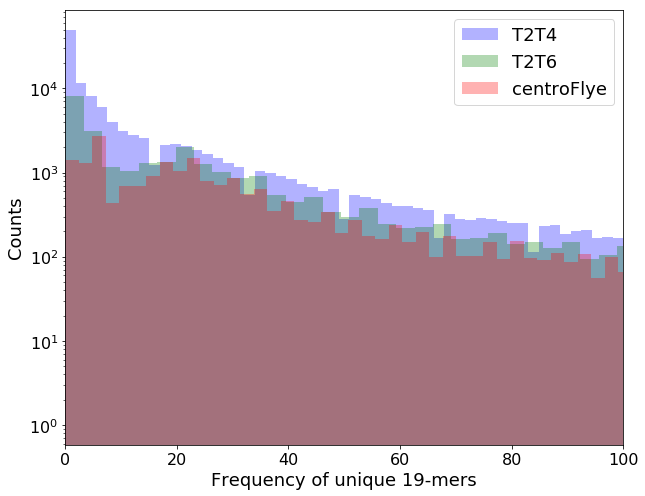

In [39]:
plt.xlim(0, 100)
plt.hist(t2t04_unique_hpc_kmers_counts, bins=1000, color='blue', alpha=0.3)
plt.hist(t2t06_unique_hpc_kmers_counts, bins=2000, color='green', alpha=0.3)
plt.hist(centroFlye_unique_hpc_kmers_counts, color='red', bins=2000, alpha=0.3)
plt.legend(['T2T4', 'T2T6', 'centroFlye'], fontsize=18)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Frequency of unique 19-mers', fontsize=18)
plt.ylabel('Counts', fontsize=18)
pass

# centroFlye deletion

In [40]:
def introduce_deletion(assembly_kmer_clouds, pos, length):
    assembly_kmer_clouds = deepcopy(assembly_kmer_clouds)
    assembly_kmer_clouds.kmers = \
        assembly_kmer_clouds.kmers[:pos] + \
        assembly_kmer_clouds.kmers[pos+length:]
    return assembly_kmer_clouds

In [41]:
centroFlye_kmer_clouds = get_reads_kmer_clouds(centroFlye_ncrf, n=1, k=19,
                                              genomic_kmers=centroFlye_unique_kmers)
centroFlye_kmer_clouds = list(centroFlye_kmer_clouds.values())[0]


In [42]:
deletion_pos=300
deletion_len=25
centroFlye_del_kmer_clouds = \
    introduce_deletion(centroFlye_kmer_clouds,
                       pos=deletion_pos,
                       length=deletion_len)


# Comparison of mapping

In [43]:
def compare_mappings(m1p, m2p,
                     xlabel, ylabel, title, step=100,
                     verbose=False):
    def onclick(event):
        print('yahoo')
        #thisline = self.event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
    
    both_mapped = set(m1p.keys()) & set(m2p.keys())
    print(f'Both mapped: {len(both_mapped)}')

    diff_triples = []
    for r_id in both_mapped:
        diff_triples.append((m1p[r_id], m2p[r_id], r_id))
        if verbose:
            print(diff_triples[-1])
    diff_triples.sort()
    xcoords = [x[0] for x in diff_triples]
    ycoords = [x[1] for x in diff_triples]
    plt.scatter(xcoords, ycoords, marker='.')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.xticks([i * step for i in range(0, max(xcoords) // step + 1)], rotation=45)
    plt.yticks([i * step for i in range(0, max(ycoords) // step + 1)])
    plt.figure().canvas.mpl_connect('pick_event', onclick)
    return diff_triples


def find_mapping_breakpoints(diff_triples, ncommon=7):
    dist = []
    for (p1, p2, r_id) in diff_triples:
        dist.append((p1 - p2, p1, p2))
    most_common_dist = Counter(x[0] for x in dist).most_common(ncommon)
    most_common_dist = [x[0] for x in most_common_dist]
    dist = [(d, p1, p2) for (d, p1, p2) in dist if d in most_common_dist]
    diff_dist = [(0, 0, 0)]
    for (d1, p11, p12), (d2, p21, p22) in zip(dist[:-1], dist[1:]):
        if d1 != d2:
            diff_dist.append((d2 - d1, (p11, p12), (p21, p22)))
    filtered_dist = []
    i = 0
    while i < len(diff_dist) - 1:
        d1, d2 = diff_dist[i], diff_dist[i+1]
        if abs(abs(d1[0]) - abs(d2[0])) <= 3:
            i += 2
        else:
            filtered_dist.append(d1)
            i += 1
    filtered_dist.append(diff_dist[-1])
    return filtered_dist

## T2T 0.4 vs centroFlye (Figure 4b)

In [44]:
t2t04_04cf_kmer_clouds = get_reads_kmer_clouds(t2t04_ncrf, n=1, k=19,
                                        genomic_kmers=t2t04_centroFlye_unique_kmers)
centroFlye_04cf_kmer_clouds = get_reads_kmer_clouds(centroFlye_ncrf, n=1, k=19,
                                                  genomic_kmers=t2t04_centroFlye_unique_kmers)
t2t04_04cf_kmer_clouds = list(t2t04_04cf_kmer_clouds.values())[0]
centroFlye_04cf_kmer_clouds = list(centroFlye_04cf_kmer_clouds.values())[0]

In [45]:
reads_kmer_clouds_04_04cf = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                                  genomic_kmers=t2t04_centroFlye_unique_kmers)

In [46]:
centroFlye_04cf_cloud_contig = CloudContig(1)
centroFlye_04cf_cloud_contig.add_read(centroFlye_04cf_kmer_clouds, 0)
centroFlye_04cf_mapped_pos, centroFlye_04cf_scores = \
    map_reads_fast(centroFlye_04cf_cloud_contig, reads_kmer_clouds_04_04cf, threshold=(3,20))


In [47]:
t2t04_04cf_cloud_contig = CloudContig(1)
t2t04_04cf_cloud_contig.add_read(t2t04_04cf_kmer_clouds, 0)
t2t04_04cf_mapped_pos, t2t04_04cf_scores = \
    map_reads_fast(t2t04_04cf_cloud_contig, reads_kmer_clouds_04_04cf, threshold=(3,20))


In [48]:
len(centroFlye_04cf_mapped_pos), len(t2t04_04cf_mapped_pos)

(1320, 1237)

Both mapped: 1234


[(0, 0, 0),
 (32, (153, 153), (154, 122)),
 (2, (444, 412), (445, 411)),
 (56, (707, 673), (774, 684)),
 (47, (1042, 952), (1072, 935)),
 (36, (1380, 1243), (1406, 1233))]

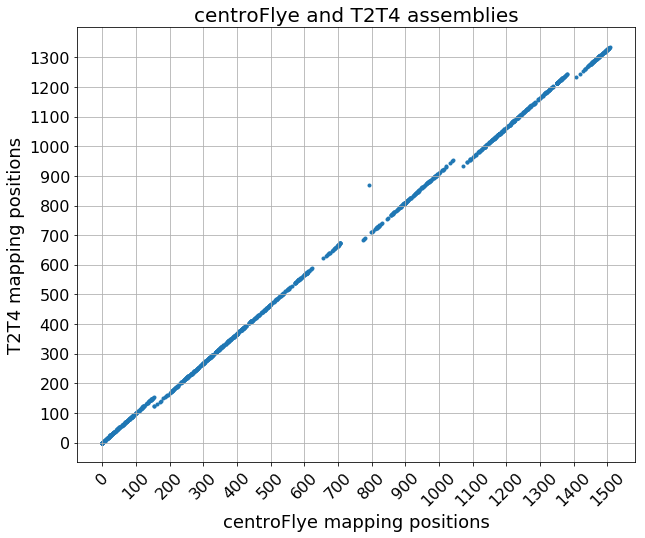

<Figure size 720x576 with 0 Axes>

In [49]:
diff_triples = compare_mappings(centroFlye_04cf_mapped_pos, t2t04_04cf_mapped_pos,
                                xlabel='centroFlye mapping positions', 
                                ylabel='T2T4 mapping positions',
                                title='centroFlye and T2T4 assemblies',
                                verbose=False)
find_mapping_breakpoints(diff_triples)

## T2T 0.6 vs centroFlye (Figure 4c)

In [50]:
t2t06_06cf_kmer_clouds = get_reads_kmer_clouds(t2t06_ncrf, n=1, k=19,
                                        genomic_kmers=t2t06_centroFlye_unique_kmers)
centroFlye_06cf_kmer_clouds = get_reads_kmer_clouds(centroFlye_ncrf, n=1, k=19,
                                                  genomic_kmers=t2t06_centroFlye_unique_kmers)
t2t06_06cf_kmer_clouds = list(t2t06_06cf_kmer_clouds.values())[0]
centroFlye_06cf_kmer_clouds = list(centroFlye_06cf_kmer_clouds.values())[0]

In [51]:
reads_kmer_clouds_06_06cf = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                                  genomic_kmers=t2t06_centroFlye_unique_kmers)

In [52]:
centroFlye_06cf_cloud_contig = CloudContig(1)
centroFlye_06cf_cloud_contig.add_read(centroFlye_06cf_kmer_clouds, 0)
centroFlye_06cf_mapped_pos, centroFlye_06cf_scores = \
    map_reads_fast(centroFlye_06cf_cloud_contig, reads_kmer_clouds_06_06cf, threshold=(3,20))


In [53]:
t2t06_06cf_cloud_contig = CloudContig(1)
t2t06_06cf_cloud_contig.add_read(t2t06_06cf_kmer_clouds, 0)
t2t06_06cf_mapped_pos, t2t06_06cf_scores = \
    map_reads_fast(t2t06_06cf_cloud_contig, reads_kmer_clouds_06_06cf, threshold=(3,20))


In [54]:
len(centroFlye_06cf_mapped_pos), len(t2t06_06cf_mapped_pos)

(1537, 1537)

Both mapped: 1535


[(0, 0, 0),
 (5, (177, 177), (180, 175)),
 (-1, (449, 444), (451, 447)),
 (56, (713, 709), (757, 697)),
 (47, (1044, 984), (1045, 938)),
 (-3, (1393, 1286), (1394, 1290)),
 (27, (1411, 1307), (1418, 1287))]

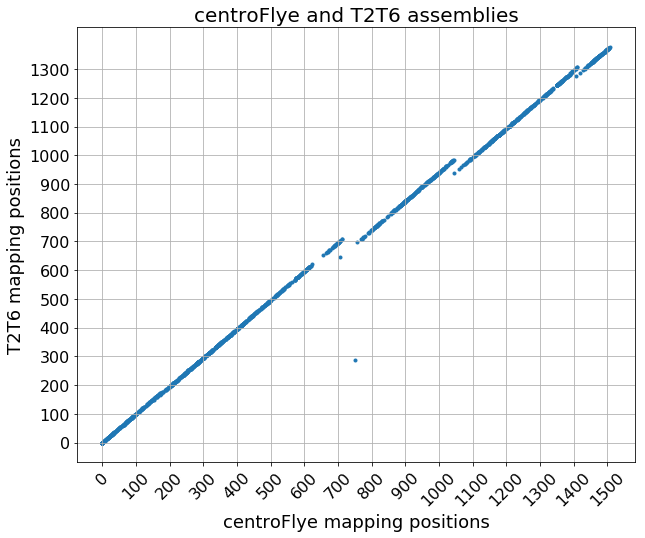

<Figure size 720x576 with 0 Axes>

In [55]:
diff_triples = compare_mappings(centroFlye_06cf_mapped_pos, t2t06_06cf_mapped_pos,
                                xlabel='centroFlye mapping positions', 
                                ylabel='T2T6 mapping positions',
                                title='centroFlye and T2T6 assemblies',
                                verbose=False)
find_mapping_breakpoints(diff_triples)

## T2T 0.6 vs T2T 0.4 (Figure 4d)

In [56]:
t2t06_0406_kmer_clouds = get_reads_kmer_clouds(t2t06_ncrf, n=1, k=19,
                                        genomic_kmers=t2t04_t2t06_unique_kmers)
t2t04_0406_kmer_clouds = get_reads_kmer_clouds(t2t04_ncrf, n=1, k=19,
                                        genomic_kmers=t2t04_t2t06_unique_kmers)
t2t06_0406_kmer_clouds = list(t2t06_0406_kmer_clouds.values())[0]
t2t04_0406_kmer_clouds = list(t2t04_0406_kmer_clouds.values())[0]


In [57]:
reads_kmer_clouds_0406 = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                          genomic_kmers=t2t04_t2t06_unique_kmers)

In [58]:
t2t06_0406_cloud_contig = CloudContig(1)
t2t06_0406_cloud_contig.add_read(t2t06_0406_kmer_clouds, 0)
t2t06_0406_mapped_pos, t2t06_0406_scores = \
    map_reads_fast(t2t06_0406_cloud_contig, reads_kmer_clouds_0406, threshold=(3,20))



In [59]:
t2t04_0406_cloud_contig = CloudContig(1)
t2t04_0406_cloud_contig.add_read(t2t04_0406_kmer_clouds, 0)
t2t04_0406_mapped_pos, t2t04_0406_scores = \
    map_reads_fast(t2t04_0406_cloud_contig, reads_kmer_clouds_0406, threshold=(3,20))



In [60]:
len(t2t06_0406_mapped_pos), len(t2t04_0406_mapped_pos)

(1316, 1266)

Both mapped: 1265


[(0, 0, 0), (-27, (153, 153), (155, 182)), (-12, (1243, 1273), (1245, 1287))]

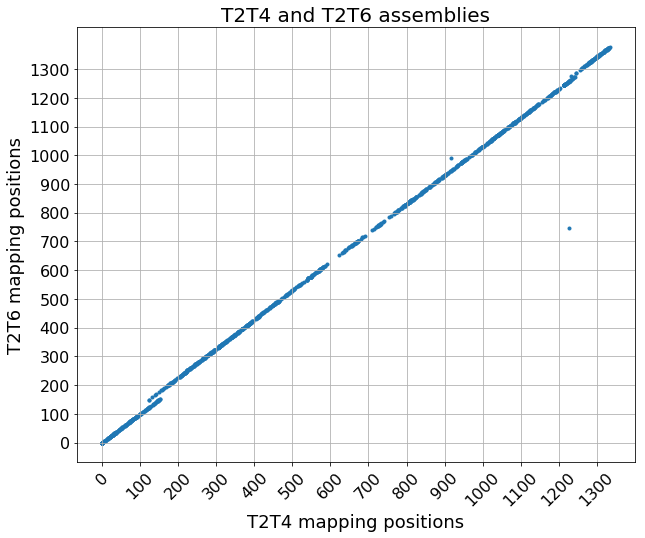

<Figure size 720x576 with 0 Axes>

In [61]:
diff_triples = compare_mappings(t2t04_0406_mapped_pos, t2t06_0406_mapped_pos,
                                xlabel='T2T4 mapping positions', 
                                ylabel='T2T6 mapping positions',
                                title='T2T4 and T2T6 assemblies',
                                verbose=False)
find_mapping_breakpoints(diff_triples)

## centroFlye vs centroFlye deletion (Figure 4a)

In [62]:
centroFlye_del_cfcfdel_cloud_contig = CloudContig(1)
centroFlye_del_cfcfdel_cloud_contig.add_read(centroFlye_del_kmer_clouds, 0)

centroFlye_del_unique_kmers = set(centroFlye_del_cfcfdel_cloud_contig.kmer_positions.keys())

In [63]:
# centroFlye_deletion_cloud_contig = CloudContig(1)
# centroFlye_deletion_cloud_contig.add_read(centroFlye_del_kmer_clouds, 0)
reads_kmer_clouds_cfcfdel = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                                  genomic_kmers=centroFlye_del_unique_kmers)

In [64]:
centroFlye_cfcfdel_cloud_contig = CloudContig(1)
centroFlye_cfcfdel_cloud_contig.add_read(centroFlye_kmer_clouds, 0)
centroFlye_cfcfdel_mapped_pos, centroFlye_cfcfdel_scores = map_reads_fast(centroFlye_cfcfdel_cloud_contig,
                                                                          reads_kmer_clouds_cfcfdel,
                                                                          threshold=(3,20))

In [65]:
centroFlye_del_cfcfdel_cloud_contig = CloudContig(1)
centroFlye_del_cfcfdel_cloud_contig.add_read(centroFlye_del_kmer_clouds, 0)
centroFlye_del_cfcfdel_mapped_pos, centroFlye_del_cfcfdel_scores = map_reads_fast(centroFlye_del_cfcfdel_cloud_contig,
                                                                                  reads_kmer_clouds_cfcfdel,
                                                                                  threshold=(3,20))

In [66]:
#for i, cloud in centroFlye_del_cfcfdel_cloud_contig.clouds.items():
#    assert len(cloud) == len(centroFlye_del_cloud_contig.clouds[i])

In [67]:
for kmer, pos in centroFlye_cfcfdel_cloud_contig.kmer_positions.items():
    if len(pos) != 1:
        print(kmer, len(pos))
    #assert len(pos) == 1
for kmer, pos in centroFlye_del_cfcfdel_cloud_contig.kmer_positions.items():
    assert len(pos) == 1

In [68]:
len(centroFlye_cfcfdel_mapped_pos), len(centroFlye_del_cfcfdel_mapped_pos)

(1670, 1676)

Both mapped: 1670


[(0, 0, 0), (25, (296, 296), (298, 273)), (-351, (650, 274), (650, 625))]

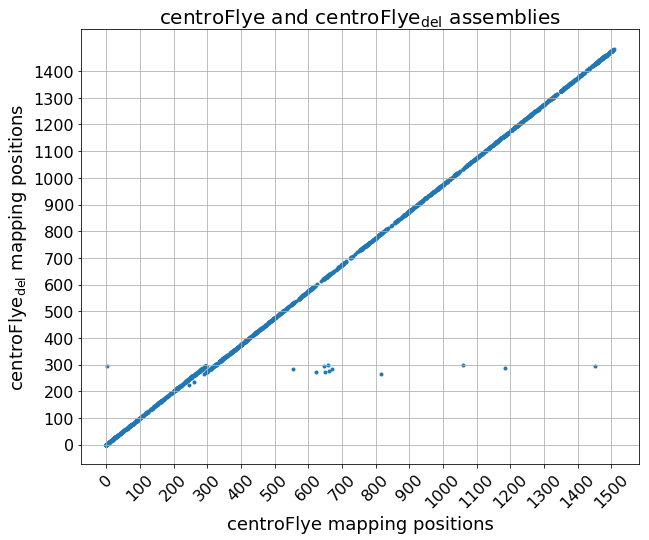

<Figure size 720x576 with 0 Axes>

In [69]:
diff_triples = compare_mappings(centroFlye_cfcfdel_mapped_pos, centroFlye_del_cfcfdel_mapped_pos,
                                xlabel='centroFlye mapping positions', 
                                ylabel=r'$\mathrm{centroFlye_{del}}$ mapping positions',
                                title=r'centroFlye and $\mathrm{centroFlye_{del}}$ assemblies',
                                verbose=False)
find_mapping_breakpoints(diff_triples)

# Coverage Test (Figure 5)

In [70]:
def get_coverage(cc, kmer_clouds, reads_ncrf, mapped_pos, unit_len=2055,
                 min_read_len=0,
                 min_score=(0, 0),
                 with_len_pred=True):
    coverage = [0] * (len(cc.clouds) + 1)
    for r_id, p in mapped_pos.items():
        read_record = reads_ncrf.records[r_id]
        if reads_ncrf.records[r_id].r_len < min_read_len:
            continue
        if min_score > (0, 0):
            score, _ = cc.calc_inters_score(kmer_clouds[r_id], min_position=p, max_position=p)
            if score < min_score:
                continue
        if with_len_pred:
            left_estimation = reads_ncrf.records[r_id].r_st // unit_len
            right_estimation = (read_record.r_len - read_record.r_en) // unit_len
        else:
            left_estimation = 0
            right_estimation = 0
        left_pos = max(0, p - left_estimation)
        right_pos = p + len(kmer_clouds[r_id].kmers) + 1 + right_estimation
        right_pos = min(len(coverage) - 1, right_pos)
        
        coverage[left_pos] += 1
        coverage[right_pos] -= 1

    coverage = list(accumulate(coverage))
    return coverage[:-1]

In [71]:
t2t04_kmer_clouds = get_reads_kmer_clouds(t2t04_ncrf, n=1, k=19,
                                        genomic_kmers=t2t04_unique_kmers)
t2t06_kmer_clouds = get_reads_kmer_clouds(t2t06_ncrf, n=1, k=19,
                                        genomic_kmers=t2t06_unique_kmers)
centroFlye_kmer_clouds
centroFlye_del_kmer_clouds

t2t06_kmer_clouds = list(t2t06_kmer_clouds.values())[0]
t2t04_kmer_clouds = list(t2t04_kmer_clouds.values())[0]


In [72]:
reads_kmer_clouds_04 = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                             genomic_kmers=t2t04_unique_kmers)
reads_kmer_clouds_06 = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                             genomic_kmers=t2t06_unique_kmers)
reads_kmer_clouds_centroFlye = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                                     genomic_kmers=centroFlye_unique_kmers)
reads_kmer_clouds_centroFlye_del = deepcopy(reads_kmer_clouds_cfcfdel)

In [73]:
t2t06_cloud_contig = CloudContig(1)
t2t06_cloud_contig.add_read(t2t06_kmer_clouds, 0)
t2t06_mapped_pos, t2t06_scores = map_reads_fast(t2t06_cloud_contig, reads_kmer_clouds_06, threshold=(3,20))

In [74]:
t2t04_cloud_contig = CloudContig(1)
t2t04_cloud_contig.add_read(t2t04_kmer_clouds, 0)
t2t04_mapped_pos, t2t04_scores = map_reads_fast(t2t04_cloud_contig, reads_kmer_clouds_04, threshold=(3,20))

In [75]:
centroFlye_cloud_contig = CloudContig(1)
centroFlye_cloud_contig.add_read(centroFlye_kmer_clouds, 0)
centroFlye_mapped_pos, centroFlye_scores = map_reads_fast(centroFlye_cloud_contig, reads_kmer_clouds_centroFlye, threshold=(3,20))

In [76]:
centroFlye_del_cloud_contig = CloudContig(1)
centroFlye_del_cloud_contig.add_read(centroFlye_del_kmer_clouds, 0)
centroFlye_del_mapped_pos, centroFlye_del_scores = \
    map_reads_fast(centroFlye_del_cloud_contig, reads_kmer_clouds_centroFlye_del, threshold=(3,20))

In [77]:
len(centroFlye_mapped_pos), len(centroFlye_del_mapped_pos)

(1696, 1676)

In [78]:
len(set(centroFlye_mapped_pos.keys()) & set(centroFlye_del_mapped_pos.keys()))

1674

In [79]:
coverage_04 = get_coverage(t2t04_cloud_contig, reads_kmer_clouds_04, reads_ncrf, t2t04_mapped_pos)
coverage_06 = get_coverage(t2t06_cloud_contig, reads_kmer_clouds_06, reads_ncrf, t2t06_mapped_pos)
coverage_centroFlye = get_coverage(centroFlye_cloud_contig, reads_kmer_clouds_centroFlye, reads_ncrf, centroFlye_mapped_pos)
coverage_centroFlye_del = get_coverage(centroFlye_del_cloud_contig, reads_kmer_clouds_centroFlye_del, reads_ncrf, centroFlye_del_cfcfdel_mapped_pos)


(0, 110)

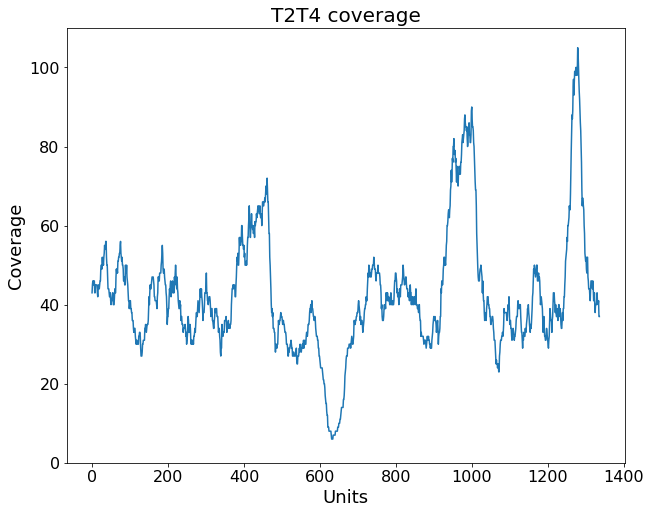

In [80]:
plt.plot(range(len(coverage_04)), coverage_04)
plt.title('T2T4 coverage', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 110))

(0, 110)

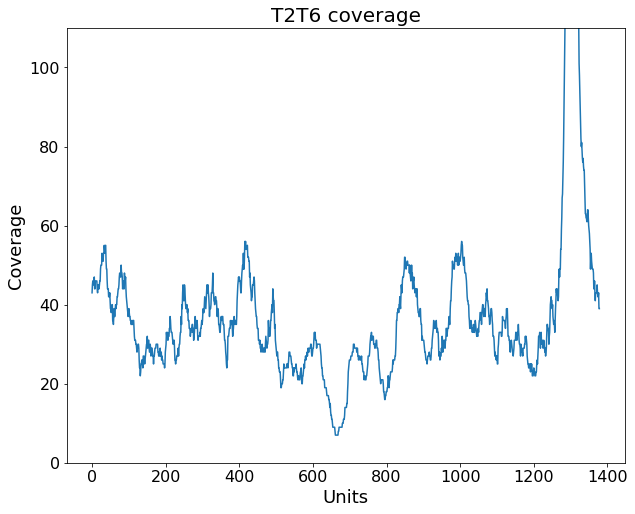

In [81]:
plt.plot(range(len(coverage_06)), coverage_06)
plt.title('T2T6 coverage', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 110))

(0, 110)

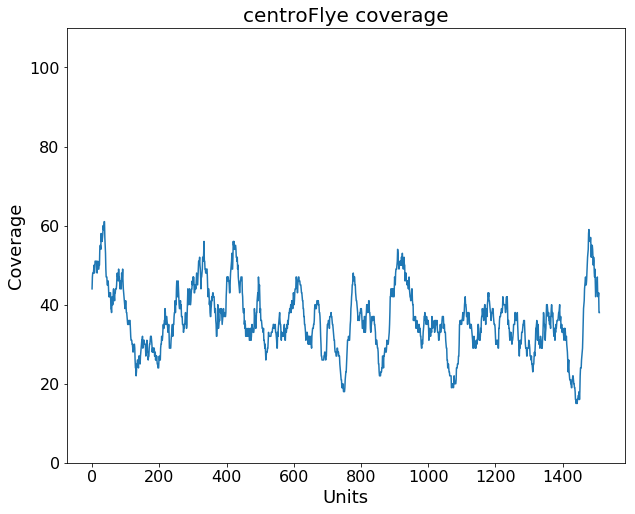

In [82]:
plt.plot(range(len(coverage_centroFlye)), coverage_centroFlye)
#plt.plot(range(len(coverage_centroFlye_deletion)), coverage_centroFlye_deletion)
#plt.legend(['centroFlye', 'centroFlye Deletion'])
plt.title('centroFlye coverage', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 110))

(0, 110)

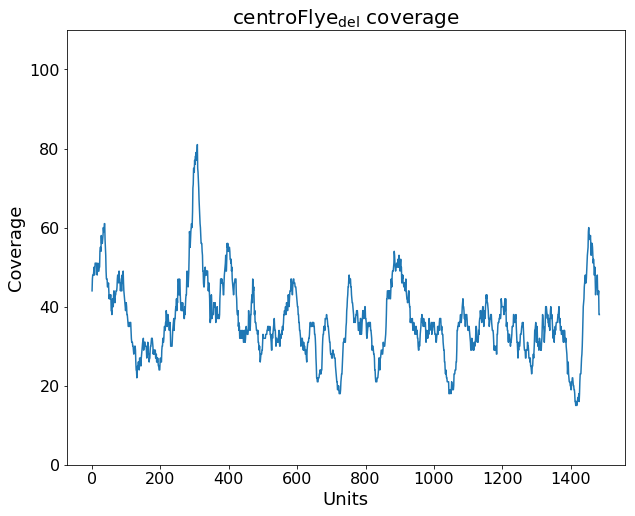

In [83]:
plt.plot(range(len(coverage_centroFlye_del)), coverage_centroFlye_del)
#plt.plot(range(len(coverage_centroFlye_deletion)), coverage_centroFlye_deletion)
#plt.legend(['centroFlye', 'centroFlye Deletion'])
plt.title('$\mathrm{centroFlye_{del}}$ coverage', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 110))

1210


(0, 110)

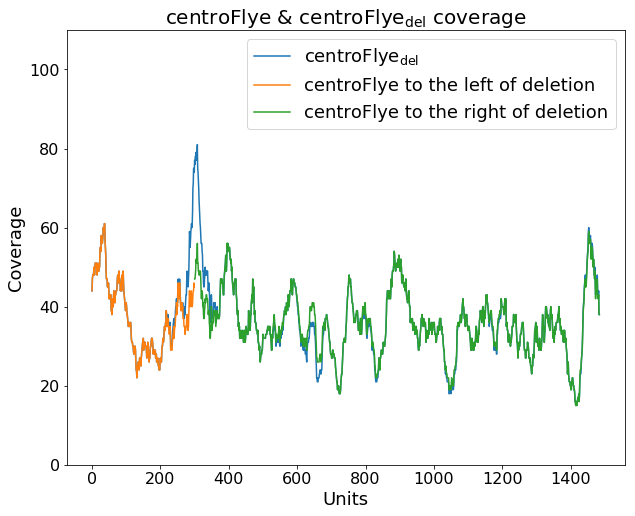

In [84]:
plt.plot(range(len(coverage_centroFlye_del)), coverage_centroFlye_del, alpha=1)
plt.plot(range(deletion_pos), coverage_centroFlye[:deletion_pos], alpha=1)
print(len(coverage_centroFlye[deletion_pos:]))
plt.plot(range(deletion_pos, len(coverage_centroFlye_del)),
         coverage_centroFlye[deletion_pos + deletion_len:],
         alpha=1)
plt.title(r'centroFlye & $\mathrm{centroFlye_{del}}$ coverage', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.legend([r'$\mathrm{centroFlye_{del}}$',
            'centroFlye to the left of deletion',
            'centroFlye to the right of deletion'],
          fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 110))

# Discordance test (Figure 3e, Figure 6)

In [85]:
def get_noncoordinated_reads(mapping_pos1, mapping_pos2, scores1, scores2, threshold=19):
    noncoord_reads_12, noncoord_reads_21 = [], []
    metric1, metric2 = 0, 0
    for r_id in mapping_pos1:
        if r_id not in mapping_pos2:
            continue
        score1 = scores1[r_id]
        score2 = scores2[r_id]
        score1 = score1[mapping_pos1[r_id]]
        score2 = score2[mapping_pos2[r_id]]
        score1 = sum(score1.values())
        score2 = sum(score2.values())
        metric1 += score1
        metric2 += score2
        
        if score1 - score2 >= threshold:
            noncoord_reads_12.append(r_id)
        if score2 - score1 >= threshold:
            noncoord_reads_21.append(r_id)
    return noncoord_reads_12, noncoord_reads_21, metric1, metric2

## T2T6 vs centroFlye

In [86]:
noncoord_reads_cf_06cf, noncoord_reads_06_06cf, noncoord_reads_cf_06cf_metric, noncoord_reads_06_06cf_metric = \
    get_noncoordinated_reads(centroFlye_06cf_mapped_pos, t2t06_06cf_mapped_pos,
                             centroFlye_06cf_scores, t2t06_06cf_scores)

In [87]:
len(noncoord_reads_cf_06cf), len(noncoord_reads_06_06cf), noncoord_reads_cf_06cf_metric, noncoord_reads_06_06cf_metric, noncoord_reads_cf_06cf_metric - noncoord_reads_06_06cf_metric



(54, 3, 383503, 377894, 5609)

In [88]:
noncoord_reads_cf_06cf_cov_cf = \
    get_coverage(centroFlye_06cf_cloud_contig, reads_kmer_clouds_06_06cf, reads_ncrf, 
                 {r_id: centroFlye_06cf_mapped_pos[r_id] for r_id in noncoord_reads_cf_06cf})
noncoord_reads_06_06cf_cov_cf = \
    get_coverage(centroFlye_06cf_cloud_contig, reads_kmer_clouds_06_06cf, reads_ncrf, 
                 {r_id: centroFlye_06cf_mapped_pos[r_id] for r_id in noncoord_reads_06_06cf})


(0, 25)

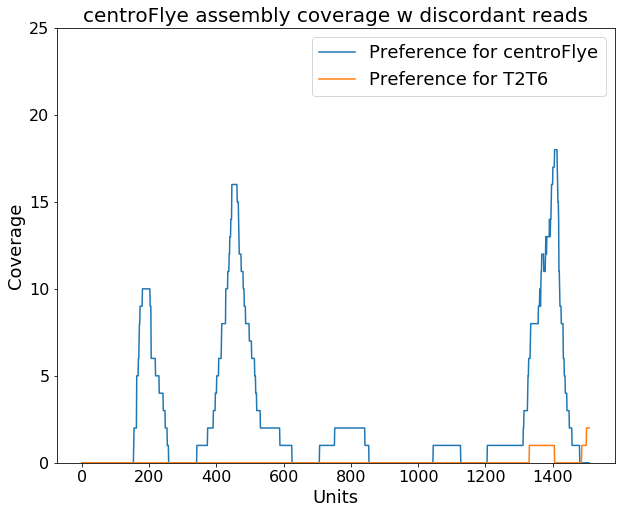

In [89]:
plt.plot(range(len(noncoord_reads_cf_06cf_cov_cf)), noncoord_reads_cf_06cf_cov_cf)
plt.plot(range(len(noncoord_reads_06_06cf_cov_cf)), noncoord_reads_06_06cf_cov_cf)
plt.legend(['Preference for centroFlye', 'Preference for T2T6'], fontsize=18)
plt.title('centroFlye assembly coverage w discordant reads', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 25))

## T2T4 vs centroFlye

In [90]:
noncoord_reads_cf_04cf, noncoord_reads_04_04cf, noncoord_reads_cf_04cf_metric, noncoord_reads_04_04cf_metric = \
    get_noncoordinated_reads(centroFlye_04cf_mapped_pos, t2t04_04cf_mapped_pos,
                             centroFlye_04cf_scores, t2t04_04cf_scores)

In [91]:
len(noncoord_reads_cf_04cf), len(noncoord_reads_04_04cf), noncoord_reads_cf_04cf_metric, noncoord_reads_04_04cf_metric, noncoord_reads_cf_04cf_metric - noncoord_reads_04_04cf_metric 



(97, 5, 257514, 250385, 7129)

In [92]:
noncoord_reads_cf_04cf_cov_cf = \
    get_coverage(centroFlye_04cf_cloud_contig, reads_kmer_clouds_04_04cf, reads_ncrf, 
                 {r_id: centroFlye_04cf_mapped_pos[r_id] for r_id in noncoord_reads_cf_04cf})
noncoord_reads_04_04cf_cov_cf = \
    get_coverage(centroFlye_04cf_cloud_contig, reads_kmer_clouds_04_04cf, reads_ncrf, 
                 {r_id: centroFlye_04cf_mapped_pos[r_id] for r_id in noncoord_reads_04_04cf})


(0, 25)

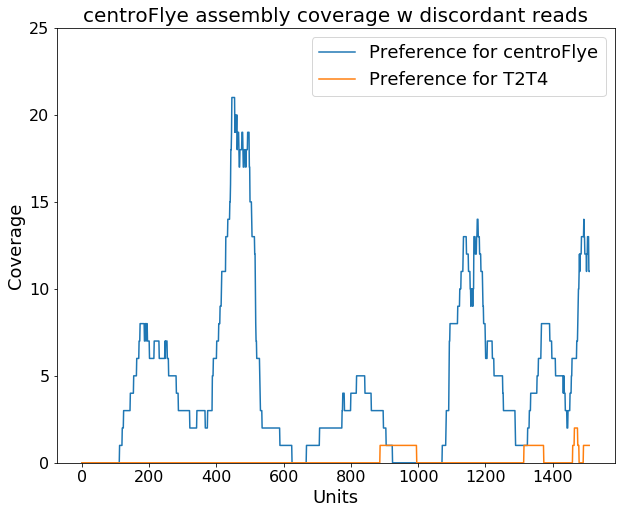

In [93]:
plt.plot(range(len(noncoord_reads_cf_04cf_cov_cf)), noncoord_reads_cf_04cf_cov_cf)
plt.plot(range(len(noncoord_reads_04_04cf_cov_cf)), noncoord_reads_04_04cf_cov_cf)
plt.legend(['Preference for centroFlye', 'Preference for T2T4'], fontsize=18)
plt.title('centroFlye assembly coverage w discordant reads', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 25))

## T2T4 vs T2T6

In [94]:
noncoord_reads_06_0406, noncoord_reads_04_0406, noncoord_reads_06_0406_metric, noncoord_reads_04_0406_metric = \
    get_noncoordinated_reads(t2t06_0406_mapped_pos, t2t04_0406_mapped_pos,
                             t2t06_0406_scores, t2t04_0406_scores)

In [95]:
len(noncoord_reads_06_0406), len(noncoord_reads_04_0406), noncoord_reads_06_0406_metric, noncoord_reads_04_0406_metric, noncoord_reads_06_0406_metric - noncoord_reads_04_0406_metric


(77, 8, 263351, 258715, 4636)

In [96]:
noncoord_reads_06_0406_cov_06 = \
    get_coverage(t2t06_0406_cloud_contig, reads_kmer_clouds_0406, reads_ncrf, 
                 {r_id: t2t06_0406_mapped_pos[r_id] for r_id in noncoord_reads_06_0406})
noncoord_reads_04_0406_cov_06 = \
    get_coverage(t2t06_0406_cloud_contig, reads_kmer_clouds_0406, reads_ncrf, 
                 {r_id: t2t04_0406_mapped_pos[r_id] for r_id in noncoord_reads_04_0406})


(0, 25)

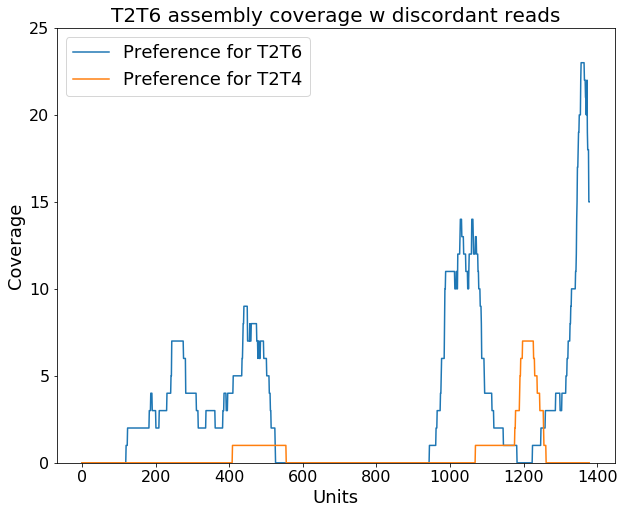

In [97]:
plt.plot(range(len(noncoord_reads_06_0406_cov_06)), noncoord_reads_06_0406_cov_06)
plt.plot(range(len(noncoord_reads_04_0406_cov_06)), noncoord_reads_04_0406_cov_06)
plt.legend(['Preference for T2T6', 'Preference for T2T4'], fontsize=18)
plt.title('T2T6 assembly coverage w discordant reads', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 25))

## centroFlye  vs centroFlye del

In [98]:
noncoord_reads_cf_cfcfdel, noncoord_reads_cfdel_cfcfdel, noncoord_reads_cf_cfcfdel_metric, noncoord_reads_cfdel_cfcfdel_metric = \
    get_noncoordinated_reads(centroFlye_cfcfdel_mapped_pos, centroFlye_del_cfcfdel_mapped_pos,
                             centroFlye_cfcfdel_scores, centroFlye_del_cfcfdel_scores)



In [99]:
len(noncoord_reads_cf_cfcfdel), len(noncoord_reads_cfdel_cfcfdel), noncoord_reads_cf_cfcfdel_metric, noncoord_reads_cfdel_cfcfdel_metric, noncoord_reads_cf_cfcfdel_metric - noncoord_reads_cfdel_cfcfdel_metric


(13, 0, 407923, 402420, 5503)

In [100]:
noncoord_reads_cf_cfcfdel_cov_cf = \
    get_coverage(centroFlye_cfcfdel_cloud_contig, reads_kmer_clouds_centroFlye_del, reads_ncrf, 
                 {r_id: centroFlye_cfcfdel_mapped_pos[r_id] for r_id in noncoord_reads_cf_cfcfdel})
noncoord_reads_cfdel_cfcfdel_cov_cf = \
    get_coverage(centroFlye_cfcfdel_cloud_contig, reads_kmer_clouds_centroFlye_del, reads_ncrf, 
                 {r_id: centroFlye_del_cfcfdel_mapped_pos[r_id] for r_id in noncoord_reads_cfdel_cfcfdel})


(0, 25)

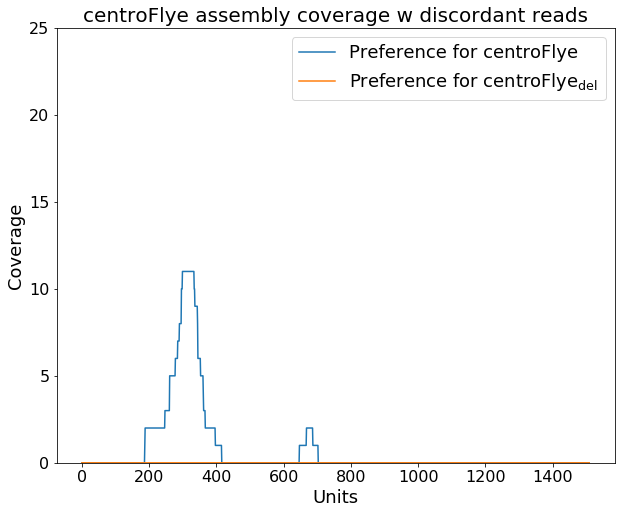

In [101]:
plt.plot(range(len(noncoord_reads_cf_cfcfdel_cov_cf)), noncoord_reads_cf_cfcfdel_cov_cf)
plt.plot(range(len(noncoord_reads_cfdel_cfcfdel_cov_cf)), noncoord_reads_cfdel_cfcfdel_cov_cf)
plt.legend(['Preference for centroFlye', r'Preference for $\mathrm{centroFlye_{del}}$'], fontsize=18)
plt.title('centroFlye assembly coverage w discordant reads', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('Coverage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 25))

# Supplementary Note 4. Analysis of centromeric reads that do not map to centroFlye assembly (Figure S4.1)

In [102]:
# centroFlye_mapped_pos_fn = "/Poppy/abzikadze/tandem_flye/py/juputer/centroFlye_paper/centroFlye_mapped_pos.txt"
# with open(centroFlye_mapped_pos_fn, 'w') as f:
#     for r_id, pos in centroFlye_mapped_pos.items():
#         print(r_id, pos, file=f)

In [103]:
unmapped_centroFlye = set(reads_kmer_clouds_centroFlye.keys()) - set(centroFlye_mapped_pos.keys())
unmapped_centroFlye_lens = [len(reads_kmer_clouds_centroFlye[r_id].kmers) for r_id in unmapped_centroFlye]
mapped_centroFlye_lens = [len(reads_kmer_clouds_centroFlye[r_id].kmers) for r_id in centroFlye_mapped_pos]

Number of unmapped/mapped reads

In [104]:
len(unmapped_centroFlye), len(centroFlye_mapped_pos), len(reads_kmer_clouds_centroFlye)

(689, 1696, 2385)

In [105]:
len(unmapped_centroFlye) / (len(unmapped_centroFlye) + len(centroFlye_mapped_pos))

0.28888888888888886

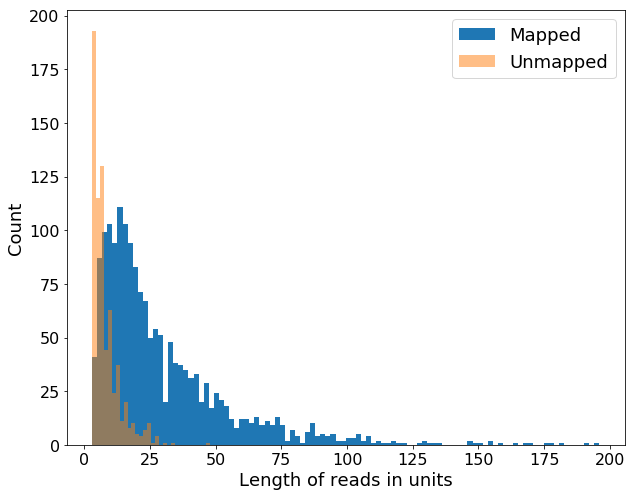

In [106]:
plt.hist(mapped_centroFlye_lens, bins=100)
plt.hist(unmapped_centroFlye_lens, bins=30, alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Length of reads in units', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(['Mapped', 'Unmapped'], fontsize=18)
pass

total length and coverage

In [107]:
list(centroFlye_ncrf.read_lens.values())[0]

3103541

In [108]:
unmapped_centroFlye_len = sum(reads_ncrf.records[r_id].r_len for r_id in unmapped_centroFlye)
unmapped_centroFlye_len

15289797

In [109]:
sum(reads_ncrf.records[r_id].r_len > 100000 for r_id in unmapped_centroFlye)

13

In [110]:
for r_id in unmapped_centroFlye:
    if reads_ncrf.records[r_id].r_len > 100000:
        print(r_id)

79cd3e66-fb26-49f7-878b-33e9f58343d9|runid=4f7e95a63e53281cff4ae6fcd4072f2d7519c26e|sampleid=CHM13_7H_1|read=60007|ch=467|start_time=2018-07-31T02:16:08Z
545dca7e-b35d-41a3-ad6d-9d21eb310097|runid=5b9e07046d3c8d04f48b3acacfff55bed7ea4d36|sampleid=CHM13_6K_2|read=7986|ch=78|start_time=2018-08-30T22:25:50Z
b9d2922b-64d4-4d04-ac48-bb468c2878bf|runid=a1867c1f175b0dcc3ab749ee37a1d53b2290fdc6|sampleid=CHM13_5C_2|read=21183|ch=377|start_time=2018-09-07T05:20:29Z
53b73df0-219a-4faa-8bb4-0b76a66f4d55|runid=f4086d32adc7dfece17e121121d85353cf44566d|sampleid=CHM13_8E_1|read=20336|ch=441|start_time=2018-10-31T23:49:56Z
6985ae38-06a6-46eb-b647-2d73d44c7eed|runid=a641f3f4ef0b300e0ff99fa7443c4173606228ab|sampleid=CHM13_6G_1|read=29178|ch=409|start_time=2018-08-24T07:57:22Z
b5c7e756-1b43-400e-8df4-2d4e9af991e2|runid=0fa748f89fb50923f27f8c5e38f960d5dcd65adb|sampleid=CHM13_8P_2|read=8697|ch=279|start_time=2018-11-08T08:09:39Z
b24f39ad-f13b-42a0-a668-22c755dbaa3b|runid=9abe87c73a2671889407854d8c761a67d3b7

In [111]:
mapped_centroFlye_len = sum(reads_ncrf.records[r_id].r_len for r_id in centroFlye_mapped_pos)
mapped_centroFlye_len

110739155

In [112]:
unmapped_centroFlye_cov = unmapped_centroFlye_len / list(centroFlye_ncrf.read_lens.values())[0]
unmapped_centroFlye_cov

4.926565171847255

In [113]:
mapped_centroFlye_cov = mapped_centroFlye_len / list(centroFlye_ncrf.read_lens.values())[0]
mapped_centroFlye_cov

35.681550525673735

In [114]:
mapped_centroFlye_cov + unmapped_centroFlye_cov

40.60811569752099

In [115]:
unmapped_centroFlye_cov / (mapped_centroFlye_cov + unmapped_centroFlye_cov)

0.12131971866274031

In [116]:
mapped_centroFlye_cov / (mapped_centroFlye_cov + unmapped_centroFlye_cov)

0.8786802813372597

In [117]:
def get_kmer_per_unit(reads_kmer_clouds):
    def get_kmer_per_unit_read(clouds):
        return np.mean([len(cloud) for cloud in clouds])
    return [get_kmer_per_unit_read(kmer_clouds.kmers) for kmer_clouds in reads_kmer_clouds.values()]

In [118]:
kmer_per_unit_centroFlye_unmapped = get_kmer_per_unit({r_id: reads_kmer_clouds_centroFlye[r_id] for r_id in unmapped_centroFlye})

kmer_per_unit_centroFlye_mapped = get_kmer_per_unit({r_id: reads_kmer_clouds_centroFlye[r_id] for r_id in centroFlye_mapped_pos})

np.mean(kmer_per_unit_centroFlye_unmapped), np.mean(kmer_per_unit_centroFlye_mapped)

(45.54667736395464, 56.827294817066594)

In [119]:
from scipy.stats import mannwhitneyu

In [120]:
mannwhitneyu(kmer_per_unit_centroFlye_unmapped, kmer_per_unit_centroFlye_mapped)

MannwhitneyuResult(statistic=264661.5, pvalue=6.450684910844062e-98)

For rare kmers:

In [121]:
reads_kmer_clouds_centroFlye_rare = get_reads_kmer_clouds(reads_ncrf, n=1, k=19,
                                                          genomic_kmers=centroFlye_rare_kmers)



In [122]:
kmer_per_unit_centroFlye_unmapped = get_kmer_per_unit({r_id: reads_kmer_clouds_centroFlye_rare[r_id] for r_id in unmapped_centroFlye})

kmer_per_unit_centroFlye_mapped = get_kmer_per_unit({r_id: reads_kmer_clouds_centroFlye_rare[r_id] for r_id in centroFlye_mapped_pos})

np.mean(kmer_per_unit_centroFlye_unmapped), np.mean(kmer_per_unit_centroFlye_mapped)

(2.316410147218684, 7.776828995280612)

In [123]:
mannwhitneyu(kmer_per_unit_centroFlye_unmapped, kmer_per_unit_centroFlye_mapped)

MannwhitneyuResult(statistic=217833.5, pvalue=5.29416161195228e-128)

# Supplementary Note 2: Breakpoint test (Figure 2.2)

In [124]:
def breakpoints(cc, reads_kmer_clouds, map_pos, min_read_len=0):
    L, R = [0] * len(cc.clouds), [0] * len(cc.clouds)
    left, right = [0] * len(cc.clouds), [0] * len(cc.clouds)
    left_ratio, right_ratio, mean_ratio = [0] * len(cc.clouds), [0] * len(cc.clouds), [0] * len(cc.clouds)
    
    for r_id, clouds in reads_kmer_clouds.items():
        if r_id not in map_pos:
            continue
        if len(clouds.kmers) < min_read_len:
            continue
        p = map_pos[r_id]
        intersections = []
        genomic_freq_clouds = []
        for i in range(len(clouds.kmers)):
            intersection = len(clouds.kmers[i] & cc.freq_clouds[i+p])
            intersections.append(intersection)
            genomic_freq_clouds.append(len(cc.freq_clouds[i+p]))
        for i in range(len(clouds.kmers)):
            if i + p >= len(left):
                continue
            left[i+p] += sum(intersections[:i+1])
            right[i+p] += sum(intersections[i:])
            L[i+p] += sum(genomic_freq_clouds[:i+1])
            R[i+p] += sum(genomic_freq_clouds[i:])
    for i in range(len(cc.clouds)):
        left_ratio[i] = left[i] / L[i] if L[i] else 1
        right_ratio[i] = right[i] / R[i] if R[i] else 1
        mean_ratio[i] = (left_ratio[i] + right_ratio[i]) / 2
    return left_ratio, right_ratio, mean_ratio

In [125]:
t2t06_left_ratio, t2t06_right_ratio, t2t06_mean_ratio = breakpoints(t2t06_cloud_contig, reads_kmer_clouds_06, t2t06_mapped_pos)
t2t04_left_ratio, t2t04_right_ratio, t2t04_mean_ratio = breakpoints(t2t04_cloud_contig, reads_kmer_clouds_04, t2t04_mapped_pos)
centroFlye_left_ratio, centroFlye_right_ratio, centroFlye_mean_ratio = breakpoints(centroFlye_cloud_contig, reads_kmer_clouds_centroFlye, centroFlye_mapped_pos)
centroFlye_deletion_left_ratio, centroFlye_deletion_right_ratio, centroFlye_deletion_mean_ratio = \
    breakpoints(centroFlye_del_cloud_contig, reads_kmer_clouds_centroFlye_del, centroFlye_del_mapped_pos)


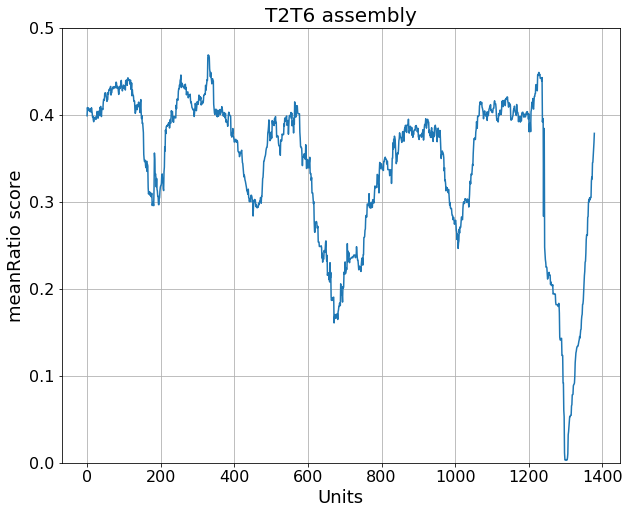

In [126]:
#plt.plot(range(len(t2t06_left_ratio)), t2t06_left_ratio)
#plt.plot(range(len(t2t06_right_ratio)), t2t06_right_ratio)
plt.plot(range(len(t2t06_mean_ratio)), t2t06_mean_ratio)

plt.title('T2T6 assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('meanRatio score', fontsize=18)
#plt.legend(['leftRatio', 'rightRatio', 'Mean'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 0.5)
plt.grid(True)

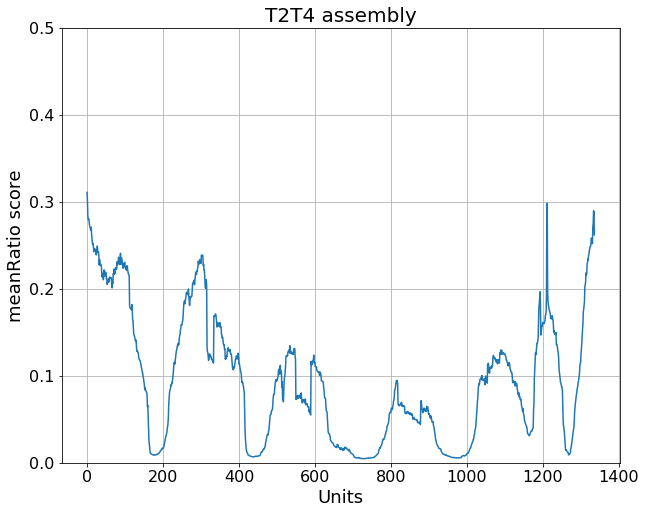

In [127]:
#plt.plot(range(len(t2t04_left_ratio)), t2t04_left_ratio)
#plt.plot(range(len(t2t04_right_ratio)), t2t04_right_ratio)
plt.plot(range(len(t2t04_mean_ratio)), t2t04_mean_ratio)

plt.title('T2T4 assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('meanRatio score', fontsize=18)
#plt.legend(['leftRatio', 'rightRatio', 'Mean'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 0.5)
plt.grid(True)

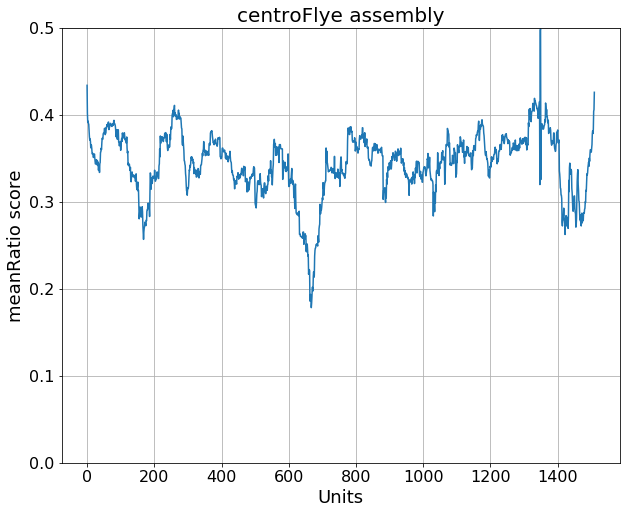

In [128]:
#plt.plot(range(len(centroFlye_left_ratio)), centroFlye_left_ratio)
#plt.plot(range(len(centroFlye_right_ratio)), centroFlye_right_ratio)
plt.plot(range(len(centroFlye_mean_ratio)), centroFlye_mean_ratio)

plt.title('centroFlye assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('meanRatio score', fontsize=18)
#plt.legend(['leftRatio', 'rightRatio', 'Mean'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 0.5)
plt.grid(True)

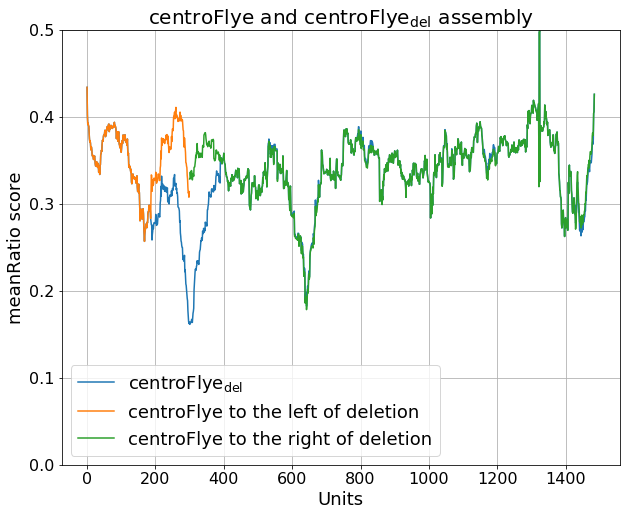

In [129]:
plt.plot(range(len(centroFlye_deletion_mean_ratio)), centroFlye_deletion_mean_ratio, alpha=1)
plt.plot(range(deletion_pos), centroFlye_mean_ratio[:deletion_pos], alpha=1)
plt.plot(range(deletion_pos, len(centroFlye_deletion_mean_ratio)),
         centroFlye_mean_ratio[deletion_pos + deletion_len:],
         alpha=1)
plt.title(r'centroFlye and $\mathrm{centroFlye_{del}}$ assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('meanRatio score', fontsize=18)
plt.legend([r'$\mathrm{centroFlye_{del}}$',
            'centroFlye to the left of deletion',
            'centroFlye to the right of deletion'],
          fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((0, 0.5))
plt.grid(True)

# Supplementary Note 2: Hanging index test (Figure S2.1)

In [130]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# cc -- cloud contig, kcs -- kmer clouds, pos -- mapping positions
def hanging_index(cc, kcs, pos, buffer=2, min_read_len=25, min_genomic_freq=5, max_inters=0, ma=5):
    left_score, right_score = [0] * len(cc.clouds), [0] * len(cc.clouds)
    average_score = [0] * len(cc.clouds)
    max_score = [0] * len(cc.clouds)
    for r_id, clouds in kcs.items():
        if r_id not in pos or len(clouds.kmers) < max(buffer, min_read_len):
            continue
        p = pos[r_id]
        intersections = []
        genomic_freq_clouds = []
        for i in range(len(clouds.kmers)):
            intersection = len(clouds.kmers[i] & cc.freq_clouds[i+p])
            genomic_freq_clouds.append(len(cc.freq_clouds[i+p]))
            intersections.append(intersection)
        if all(inters <= max_inters for inters in intersections[:buffer]):
            i = 0
            while i < len(intersections) and intersections[i] <= max_inters:
                if genomic_freq_clouds[i] >= min_genomic_freq:
                    left_score[i+p] += 1
                i += 1
        if all(inters <= max_inters for inters in intersections[-buffer:]):
            i = len(intersections) - 1
            while i >= 0 and intersections[i] <= max_inters:
                if genomic_freq_clouds[i] >= min_genomic_freq:
                    right_score[i+p] += 1
                i -=1
    
    coverage = [0] * (len(cc.clouds) + 1)
    for r_id, p in pos.items():
        if len(kcs[r_id].kmers) < max(buffer, min_read_len):
            continue
        coverage[p] += 1
        right_pos = p + len(kcs[r_id].kmers) + 1
        right_pos = min(right_pos, len(coverage) - 1)
        coverage[right_pos] -= 1
    coverage = coverage[:-1]
    coverage = list(accumulate(coverage))
    for i in range(len(cc.clouds)):
        left_score[i] /= coverage[i] if coverage[i] != 0 else 1
        right_score[i] /= coverage[i] if coverage[i] != 0 else 1
        average_score[i] = (left_score[i] + right_score[i]) / 2
        max_score[i] = max(left_score[i], right_score[i])
    average_score = moving_average(average_score, n=ma)
    return left_score, right_score, average_score, max_score

In [131]:
t2t04_l_bp, t2t04_r_bp, t2t04_av_bp, t2t04_max_bp = hanging_index(t2t04_cloud_contig, reads_kmer_clouds_04, t2t04_mapped_pos)
t2t06_l_bp, t2t06_r_bp, t2t06_av_bp, t2t06_max_bp = hanging_index(t2t06_cloud_contig, reads_kmer_clouds_06, t2t06_mapped_pos)
centroFlye_l_bp, centroFlye_r_bp, centroFlye_av_bp, centroFlye_max_bp = \
    hanging_index(centroFlye_cloud_contig, reads_kmer_clouds_centroFlye, centroFlye_mapped_pos)

centroFlye_deletion_l_bp, centroFlye_deletion_r_bp, centroFlye_deletion_av_bp, centroFlye_deletion_max_bp = \
    hanging_index(centroFlye_del_cloud_contig, reads_kmer_clouds_centroFlye_del, centroFlye_del_mapped_pos)



In [132]:
hanging_index_cutoff = 0.15

(0, 0.3)

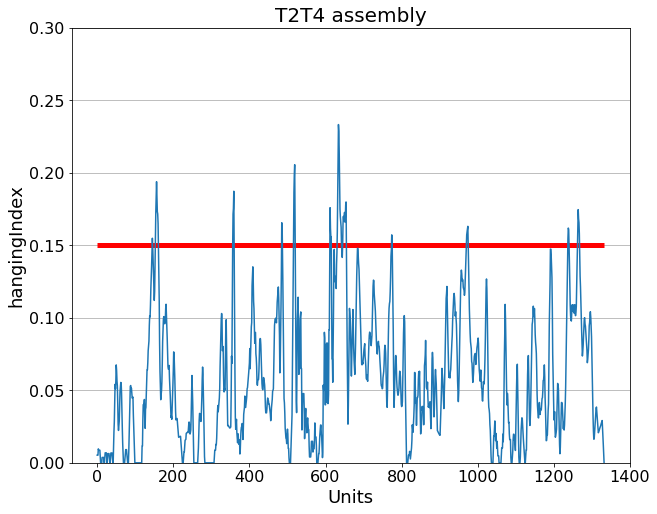

In [133]:
plt.plot(range(len(t2t04_av_bp)), t2t04_av_bp)
plt.hlines(hanging_index_cutoff, 0, len(t2t04_av_bp), color='red', linewidth=5, alpha=1)
#plt.plot(range(len(t2t06_av_bp)), t2t06_av_bp)
#plt.plot(range(len(centroFlye_av_bp)), centroFlye_av_bp)
plt.title('T2T4 assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('hangingIndex', fontsize=18)
# plt.legend(['T2T6', 'centroFlye'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, axis='y')

plt.ylim(0, 0.3)

(0, 0.3)

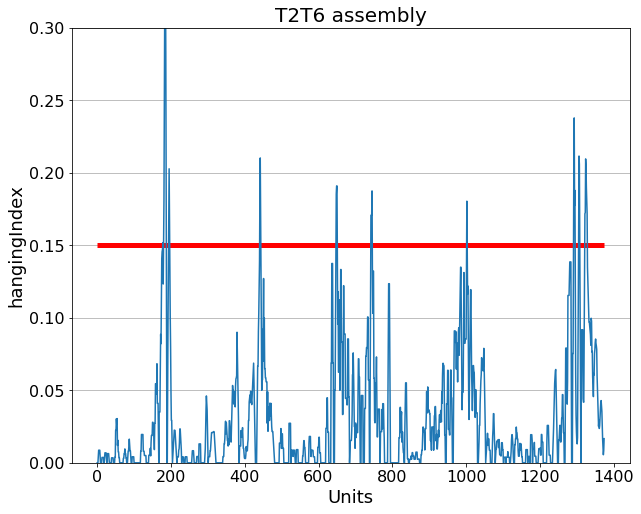

In [134]:
# plt.plot(range(len(t2t06_l_bp)), t2t06_l_bp)
# plt.plot(range(len(t2t06_r_bp)), t2t06_r_bp)
plt.plot(range(len(t2t06_av_bp)), t2t06_av_bp)
plt.hlines(hanging_index_cutoff, 0, len(t2t06_av_bp), color='red', linewidth=5, alpha=1)
#plt.plot(range(len(centroFlye_av_bp)), centroFlye_av_bp)
plt.title('T2T6 assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('hangingIndex', fontsize=18)
# plt.legend(['T2T6', 'centroFlye'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, axis='y')

plt.ylim(0, 0.3)

(0, 0.3)

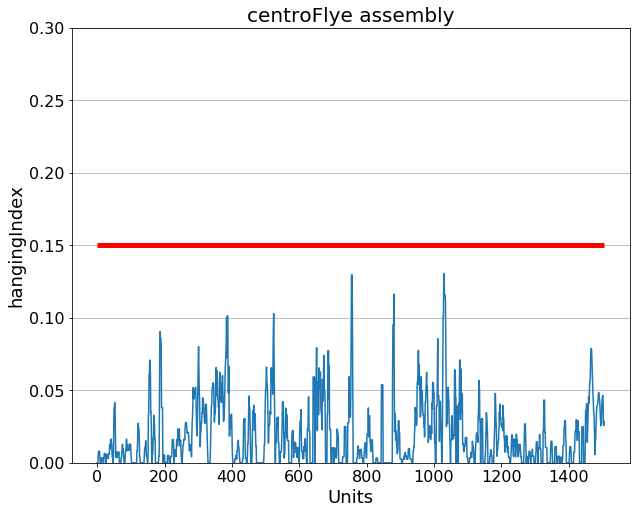

In [135]:
#plt.plot(range(len(centroFlye_l_bp)), centroFlye_l_bp)
#plt.plot(range(len(centroFlye_r_bp)), centroFlye_r_bp)
plt.plot(range(len(centroFlye_av_bp)), centroFlye_av_bp)
plt.hlines(hanging_index_cutoff, 0, len(centroFlye_av_bp), color='red', linewidth=5, alpha=1)

plt.title('centroFlye assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('hangingIndex', fontsize=18)
# plt.legend(['Left', 'Right', 'Average'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, axis='y')

plt.ylim(0, 0.3)

(0, 0.3)

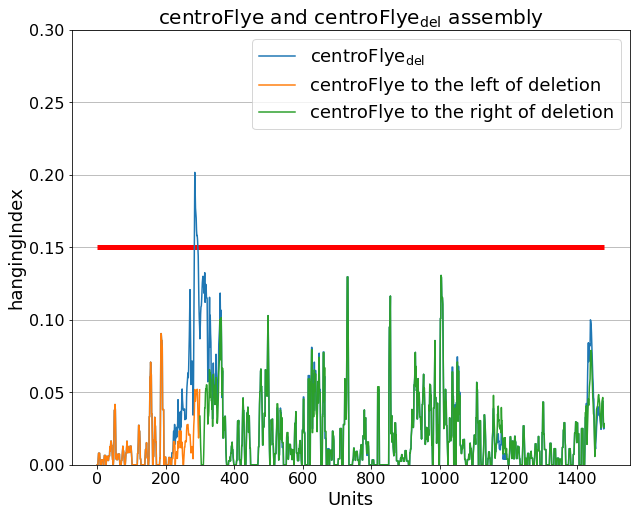

In [136]:
plt.plot(range(len(centroFlye_deletion_av_bp)), centroFlye_deletion_av_bp, alpha=1)
plt.plot(range(deletion_pos), centroFlye_av_bp[:deletion_pos], alpha=1)
plt.plot(range(deletion_pos, len(centroFlye_deletion_av_bp)),
         centroFlye_av_bp[deletion_pos + deletion_len:],
         alpha=1)
plt.hlines(hanging_index_cutoff, 0, len(centroFlye_deletion_av_bp), color='red', linewidth=5, alpha=1)
plt.title('centroFlye and $\mathrm{centroFlye_{del}}$ assembly', fontsize=20)
plt.xlabel('Units', fontsize=18)
plt.ylabel('hangingIndex', fontsize=18)
plt.legend(['$\mathrm{centroFlye_{del}}$',
            'centroFlye to the left of deletion',
            'centroFlye to the right of deletion'],
          fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, axis='y')

plt.ylim(0, 0.3)

## Mean hanging index

In [137]:
print(f'Mean hangingIndex in centroFlye del {np.mean(centroFlye_deletion_av_bp)}')
print(f'Mean hangingIndex in centroFlye {np.mean(centroFlye_av_bp)}')
print(f'Mean hangingIndex in T2T4 {np.mean(t2t04_av_bp)}')
print(f'Mean hangingIndex in T2T6 {np.mean(t2t06_av_bp)}')


Mean hangingIndex in centroFlye del 0.02359677125719286
Mean hangingIndex in centroFlye 0.019454698521064028
Mean hangingIndex in T2T4 0.05782721144648599
Mean hangingIndex in T2T6 0.031499326827772234


In [138]:
print(f'Max hangingIndex in centroFlye del {np.max(centroFlye_deletion_av_bp)}')
print(f'Max hangingIndex in centroFlye {np.max(centroFlye_av_bp)}')
print(f'Max hangingIndex in T2T4 {np.max(t2t04_av_bp)}')
print(f'Max hangingIndex in T2T6 {np.max(t2t06_av_bp)}')


Max hangingIndex in centroFlye del 0.20171926666470963
Max hangingIndex in centroFlye 0.13063856960408698
Max hangingIndex in T2T4 0.23333333333333356
Max hangingIndex in T2T6 0.40037643515904386
